* FTLE for 01-Oct-2019
* delta0 (inital separation in degrees) 
1/64 and 1/8
* integration time.
15d and 30d

* backward o forward? Forward

* FSLE Vero: df=10*d0, 

* Lat: 32-36
* Lon: 348-352 (-12, -8)

We then instatiate a `FieldSet` with the velocity field data from GlobCurrent dataset. https://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/description

In [1]:
%matplotlib inline
from datetime import timedelta, datetime
from glob import glob
import xarray as xr
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter#
import matplotlib.ticker as mticker

In [2]:
# %load_ext version_information
# %version_information numpy, xarray, parcels

In [3]:
# Parameters:

#Particle_AZO_grid100000_notides_Dec_week01_hourly.nc
grid_name = "1-64grid"
nyear = 2019
nmonth = 10
simu_length = 15. # monthly # days
domain = [360.-12, 360.-8, 32., 36.] #lomin, lomax, lamin, lamax

# Defining grid of starting particles:

if grid_name == "1-8grid":
    step = .125 # degrees
elif grid_name == "1-64grid":
    step = 0.015625 # 1./64degrees
else:
    print("Error")
    fszfasgasg

data_path = '../validation/'
fname = 'datos_Laura.nc'

only_ocean_release = True

In [4]:
outdir = '../data/'

# Define start date:
start_day = 1 #[1, 8, 15, 22]

outname_spec =  "Particle_MOR_fFTLE_"

# Checking input data:

In [5]:
ds_in = xr.open_dataset(data_path + fname)
ds_in

<xarray.Dataset>
Dimensions:    (time: 92, latitude: 41, longitude: 140)
Coordinates:
  * time       (time) datetime64[ns] 2019-10-01 2019-10-02 ... 2019-12-31
  * latitude   (latitude) float32 30.12 30.38 30.62 30.88 ... 39.62 39.88 40.12
  * longitude  (longitude) float32 325.1 325.4 325.6 325.9 ... 359.4 359.6 359.9
Data variables:
    adt        (time, latitude, longitude) float64 ...
    ugos       (time, latitude, longitude) float64 ...
    vgos       (time, latitude, longitude) float64 ...
Attributes: (12/45)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    time_coverage_duration:          P1D
    time_coverage_end:               2020-03-07T00:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2020-03-07T00:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...
    History:                         Translated to CF-1.0 Conventions by Netc...

In [6]:
(ds_in.longitude[1] - ds_in.longitude[0]).values # data resolution

array(0.25, dtype=float32)

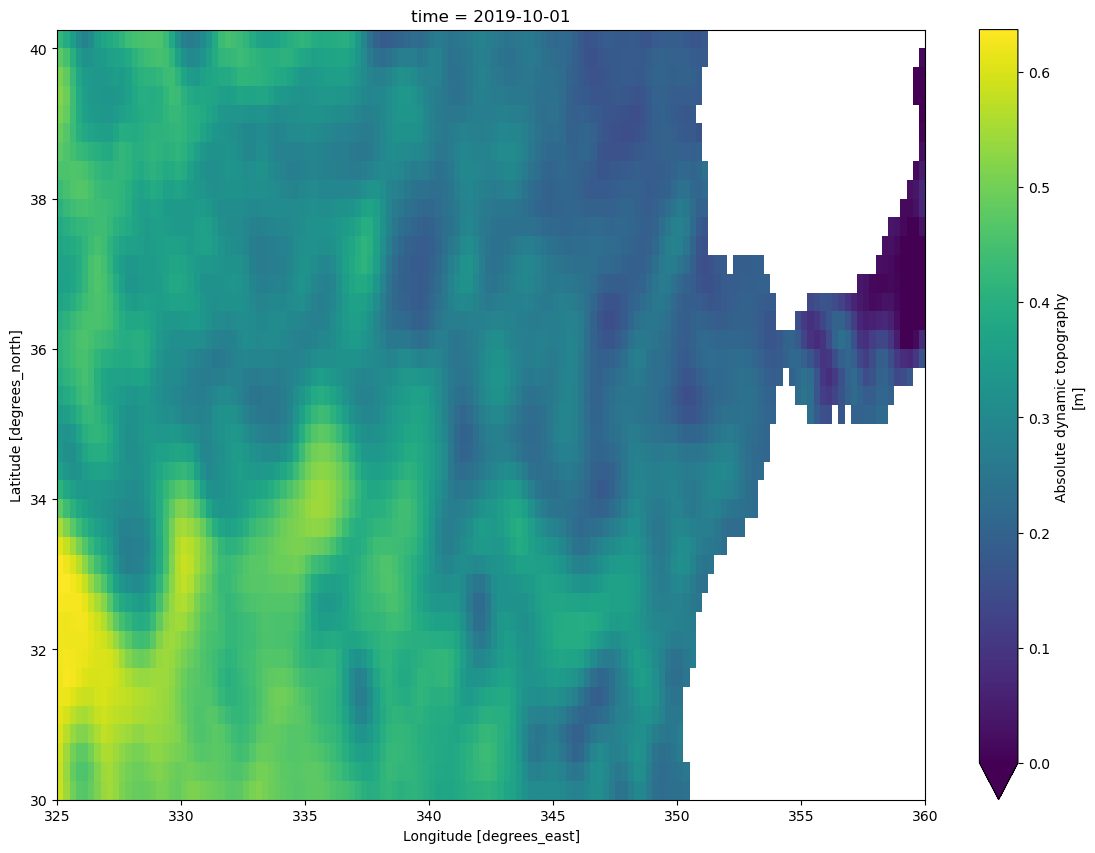

In [7]:
ds_in.adt[0,:,:].plot(figsize=(14,10), vmin=0)

## Zooming in release area:

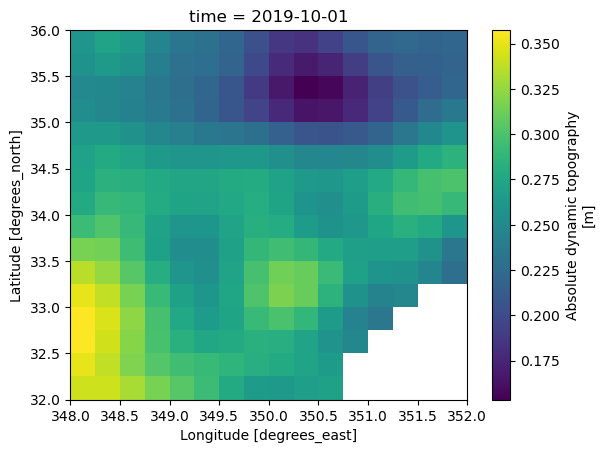

In [8]:
# as lon and lat depend only on each, need to do where in 2 parts
ds_in_zoom = ds_in.where((ds_in.longitude>domain[0]) & (ds_in.longitude<domain[1]), drop=True)
ds_in_zoom = ds_in_zoom.where((ds_in_zoom.latitude>domain[2])  & (ds_in_zoom.latitude<domain[3]), drop=True)
ds_in_zoom.adt[0,:,:].plot()

## Obtaining landmask:

Land = 0, Ocean = 1 

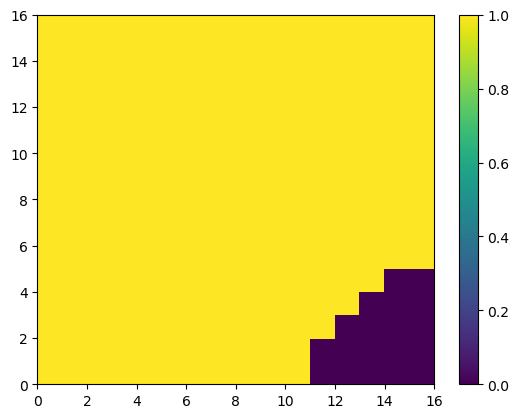

In [9]:
adt_ma = ds_in_zoom.adt[0,:,:].to_masked_array()
maska = np.ones_like(adt_ma)
maska[adt_ma.mask] = 0.
plt.pcolor(maska); plt.colorbar()


# Running function:

In [10]:
datetime_in = datetime(nyear, nmonth, start_day, 0, 0)
filename = data_path + fname
outname = outdir + outname_spec + grid_name + "_" + str(nmonth).zfill(2) + str(start_day).zfill(2) + "_" + str(simu_length)[0:2] + "d"

In [11]:
import sys
sys.path.insert(0, "../code/")
import release_and_simu as sim

In [12]:
lons, lats = sim.release_particles(grid_name, domain)

In [13]:
# remove land particles from the lats, lons if only_ocean_release is True
if only_ocean_release:
    mask_lon, mask_lat = ds_in_zoom.adt[0,:,:].longitude, ds_in_zoom.adt[0,:,:].latitude

    x, y = np.meshgrid(mask_lon, mask_lat)

    land_val_release = griddata((x.ravel(),y.ravel()), maska.ravel(),
                            (lons, lats), method='nearest', fill_value=0) 

    bool_mask = land_val_release.astype(bool)
    ocean_lons = lons[bool_mask]
    ocean_lats = lats[bool_mask]
    print(len(ocean_lats))


61072


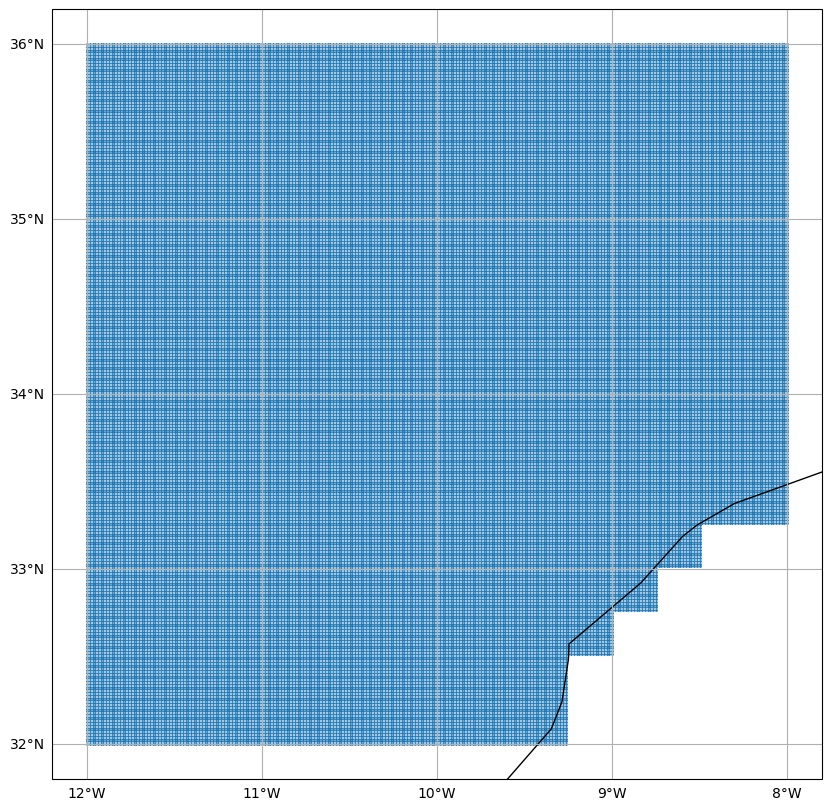

In [14]:
plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(ocean_lons, ocean_lats, s=1, transform=ccrs.PlateCarree()) #marker='o'
# ax1.set_xlim([6, 11])
# ax1.set_ylim([54.5, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


In [15]:

sim.parcels_simulation(datetime_in, ocean_lons, ocean_lats, simu_length, filename, outname)


INFO: Output files are stored in ../data/Particle_MOR_fFTLE_1-64grid_1001_15d.zarr.
100%|██████████| 1296000.0/1296000.0 [00:08<00:00, 150203.76it/s]


# Checking the outputs:

In [18]:
ds = xr.open_zarr(outname + '.zarr')
ds

<xarray.Dataset>
Dimensions:     (trajectory: 61072, obs: 60)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 8 9 ... 51 52 53 54 55 56 57 58 59
  * trajectory  (trajectory) int64 0 1 2 3 4 5 ... 61067 61068 61069 61070 61071
Data variables:
    lat         (trajectory, obs) float32 dask.array<chunksize=(61072, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 dask.array<chunksize=(61072, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] dask.array<chunksize=(61072, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 dask.array<chunksize=(61072, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4
    parcels_mesh:           spherical
    parcels_version:        v3.0.0-41-g6507fe3a

## Plotting

### All particles at all times:

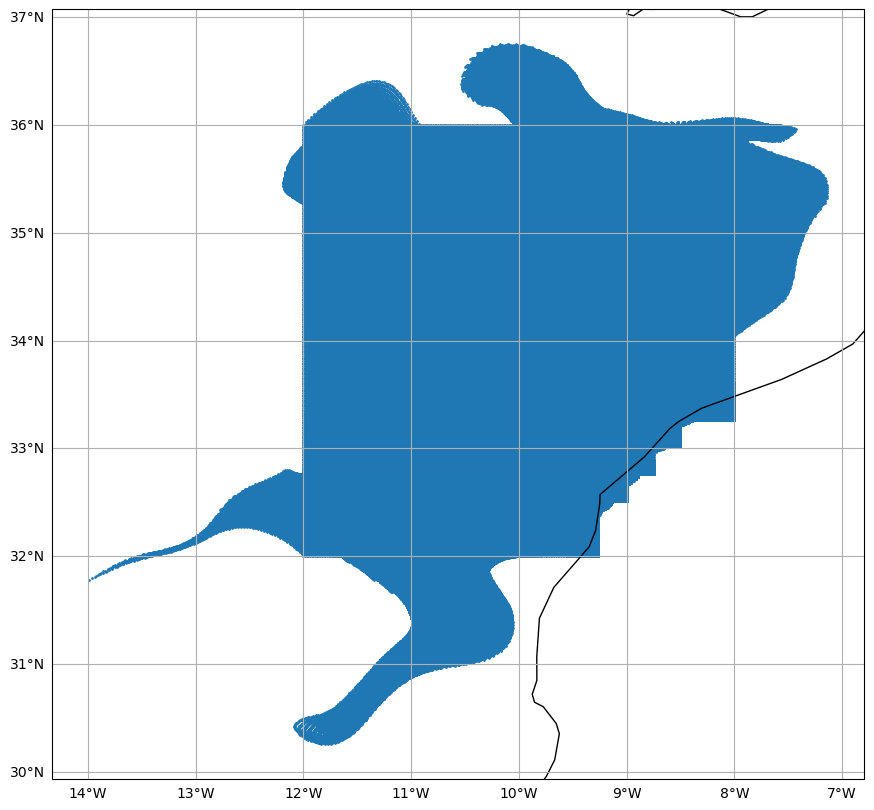

In [19]:
plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(ds['lon'], ds['lat'], s=1, transform=ccrs.PlateCarree()) #marker='o'
# ax1.set_xlim([6, 11])
# ax1.set_ylim([54.5, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


### All particles at last timestep:

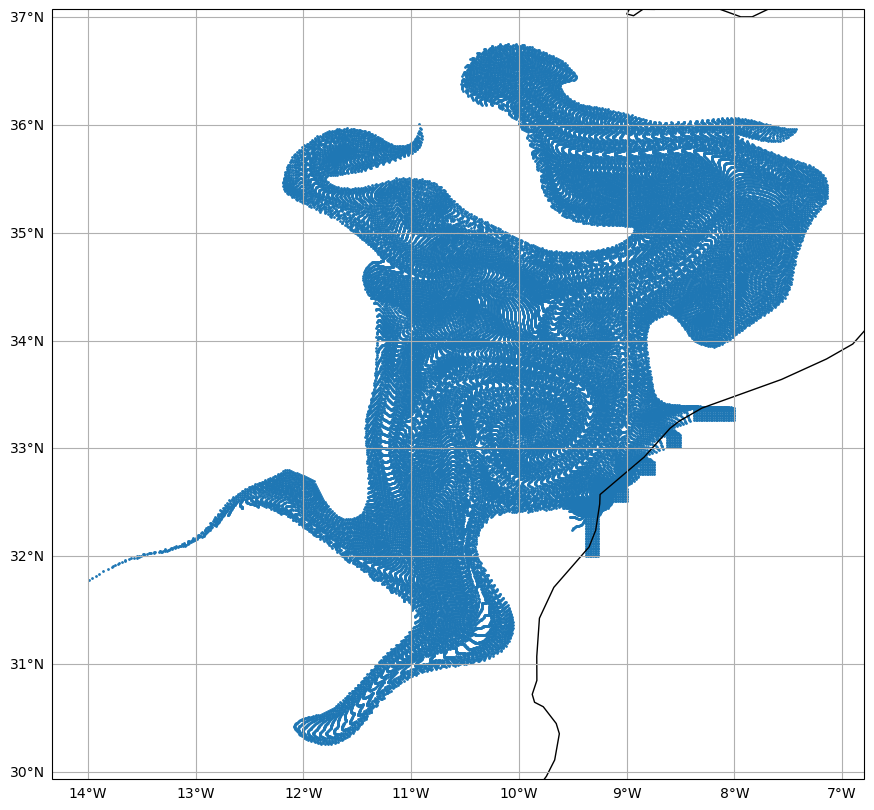

In [20]:
plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], s=1, transform=ccrs.PlateCarree()) #marker='o'
# ax1.set_xlim([6, 11])
# ax1.set_ylim([54.5, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
